In [3]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [4]:
csvfile_path = 'data.csv'
df = pd.read_csv("data.csv")


C:\Users\jiang\AppData\Local\Temp\ipykernel_26156\213187085.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


In [5]:
filtered_df = df[(df['Latitude'] != 0.00000) & (df['Longitude'] != 0.00000)]

# Save filtered data back to CSV file
filtered_df.to_csv('data_filtered.csv', index=False)

In [6]:
filtered_df['Longitude'] = filtered_df['Longitude'].astype(float)
filtered_df['Latitude'] = filtered_df['Latitude'].astype(float)

C:\Users\jiang\AppData\Local\Temp\ipykernel_26156\3438637479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Longitude'] = filtered_df['Longitude'].astype(float)
C:\Users\jiang\AppData\Local\Temp\ipykernel_26156\3438637479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Latitude'] = filtered_df['Latitude'].astype(float)


In [7]:
crimes = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(
        filtered_df['Longitude'],
        filtered_df['Latitude']
    )
)

In [5]:
# crimes.fillna("na", inplace=True)

C:\Users\jiang\AppData\Local\Temp\ipykernel_45144\3108214605.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  crimes.fillna("na", inplace=True)


In [8]:
crimes.columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC',
       'PARKS_NM', 'PD_CD', 'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon', 'geometry'],
      dtype='object')

In [9]:
mh_bbox = crimes.total_bounds

#filter it before run it

In [10]:
mh_bbox

array([-74.254555,  40.499315, -73.700286,  40.912714])

In [11]:
#use the osmnx library to create a street network graph within the bounding box defined by mh_bbox. 

mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

C:\Users\jiang\AppData\Local\Temp\ipykernel_26156\1722063500.py:3: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [12]:
# convert a street network graph into GeoDataFrames for nodes and edges using the osmnx library

mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network) 

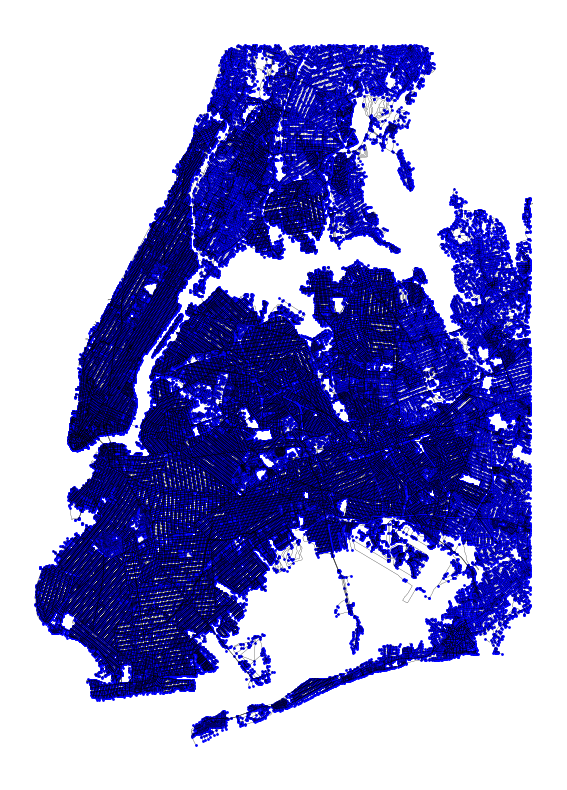

In [26]:
#plot the edges of the street network. 
ax = mh_net_edges.plot(
    color="black", 
    linewidth=0.1, 
    figsize=(10, 10))

#plot the nodes of the street network on the same axes as the edges.
mh_net_nodes.plot(ax=ax, color="blue", markersize=1).set_axis_off()

In [13]:
# start point 

my_apartment = Point(-73.958919, 40.809089)  
orig = ox.distance.nearest_nodes(mh_network, my_apartment.x, my_apartment.y)

In [14]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, my_apartment.x, my_apartment.y)      #   Original Point 
# Select a random sample from the 'mh_restaurants' GeoDataFrame by choosing a restaurant
sample = crimes.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]      #   Destination 

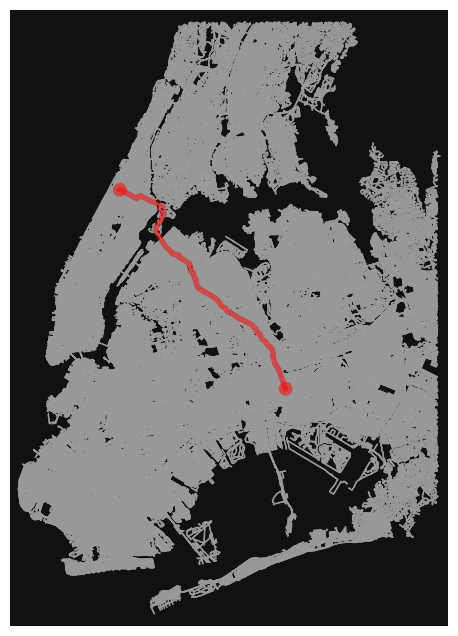

In [15]:
# find the shortest path between nodes, minimizing travel time, then plot it

route = ox.shortest_path(mh_network, orig, dest, weight="length")

fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)



In [19]:
crimes.OFNS_DESC.value_counts() 

OFNS_DESC
PETIT LARCENY                     52827
HARRASSMENT 2                     41741
ASSAULT 3 & RELATED OFFENSES      30799
GRAND LARCENY                     23621
CRIMINAL MISCHIEF & RELATED OF    19644
                                  ...  
LOITERING/GAMBLING (CARDS, DIC        3
ANTICIPATORY OFFENSES                 2
FORTUNE TELLING                       2
OTHER TRAFFIC INFRACTION              1
LOITERING                             1
Name: count, Length: 63, dtype: int64

In [20]:
ny_burglary = crimes[crimes.OFNS_DESC == "BURGLARY"]

<Axes: >

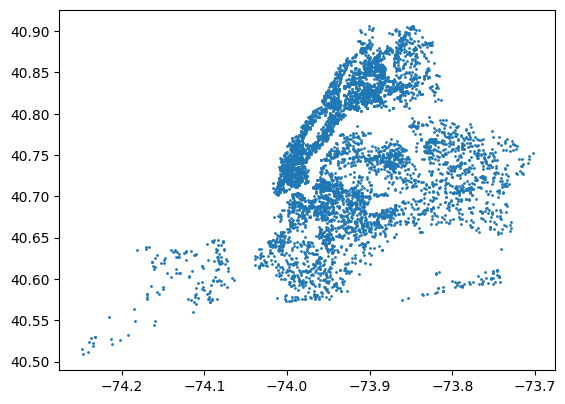

In [21]:
ny_burglary.plot(markersize=1)

In [22]:
mh_burglary = crimes[(crimes.OFNS_DESC == "BURGLARY") & (crimes.BORO_NM == "MANHATTAN")]

<Axes: >

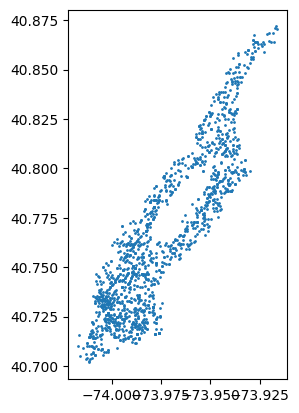

In [23]:
mh_burglary.plot(markersize=1)

In [24]:
mh_burglary_time = crimes[(crimes.OFNS_DESC == "BURGLARY") & (crimes.BORO_NM == "MANHATTAN") & ((crimes.CMPLNT_FR_TM >= "10:00:00") & (crimes.CMPLNT_FR_TM <= "11:00:00"))] 

<Axes: >

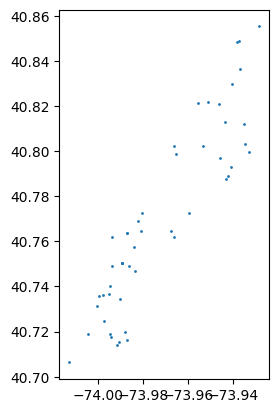

In [25]:
mh_burglary_time.plot(markersize=1)

In [26]:
def distance_from_point(row, origin):
    #row: A row from a pandas DataFrame that contains the coordinates of a point.
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    #Finds the nearest node in the network to the given point (row.geometry.x and row.geometry.y).
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    #weight="length": Uses edge length as the weight for path calculation.
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]
    #ox.routing.route_to_gdf(...): Converts the route to a GeoDataFrame.
    #["length"]: Extracts the lengths of each edge in the route.

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    #route_geom: Contains the geometry of the route as a GeoDataFrame.
    route_geom = route_geom.geometry.unary_union
    #unary_union: Combines all the geometries in the GeoDataFrame into a single geometry (useful for plotting). 

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}
    #"distance": sum(edge_lengths) / 1609.34: The distance of the route in miles.
    #route_geom": The combined geometry of the route. 

In [27]:
mh_burglary_time["distance_from_my_apartment"] = mh_burglary_time.apply(
    distance_from_point, origin=orig, axis=1
)

C:\Users\jiang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [28]:
mh_burglary_time.columns

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC',
       'PARKS_NM', 'PD_CD', 'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon', 'geometry',
       'distance_from_my_apartment'],
      dtype='object')

In [30]:
# explode the dictionary into separate columns

mh_burglary_time = pd.concat(
    [
        mh_burglary_time.drop(["distance_from_my_apartment"], axis=1),
        mh_burglary_time["distance_from_my_apartment"].apply(pd.Series),
    ],
    axis=1,
)

In [31]:
# creates a GeoDataFrame for the mh_pizza DataFrame with a specific geometry column.

mh_burglary_time_routes = gpd.GeoDataFrame(mh_burglary_time, geometry="route_geom", crs="EPSG:4326")


TypeError: 'GeoDataFrame' object is not callable

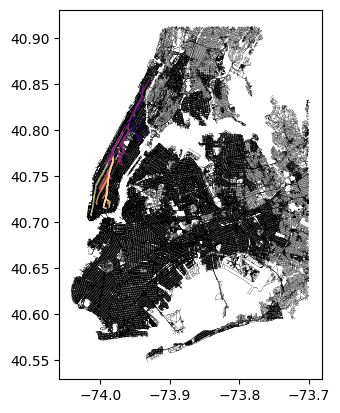

In [32]:
# Use geopandas and matplotlib libraries to visualize spatial data

ax = gpd.GeoSeries(my_apartment).plot(color="black")

mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

mh_burglary_time_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=1)

mh_burglary_time_routes(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()



# label each point
for x, y, label in zip(mh_burglary_time.geometry.x, mh_burglary_time.geometry.y, mh_burglary_time.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(my_apartment.x, my_apartment.y, "My Apartment", fontsize=2)


# title
plt.title("Distance from My Apartment to \n Burglary Crime from 10:00 am to 11:00 am in Manhattan")

AttributeError: 'GeoDataFrame' object has no attribute 'dba'

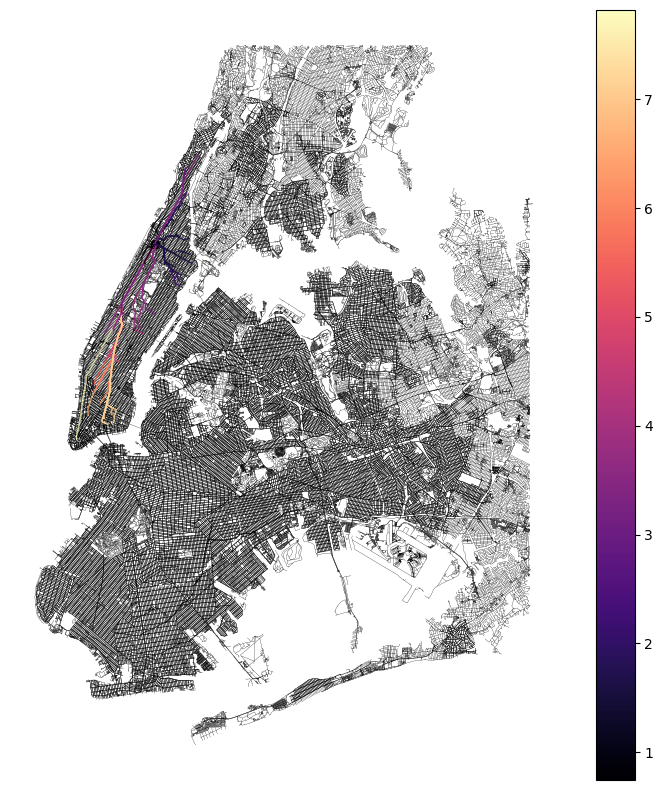

In [33]:
# Create a plot with a specific size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot my apartment location
gpd.GeoSeries(my_apartment).plot(ax=ax, color="black", label="My Apartment")

# Plot Manhattan network edges
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

# Plot routes colored by distance using the 'magma' colormap
mh_burglary_time_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=1, legend=True)

# Remove the axes for a cleaner look
ax.set_axis_off()

# Add labels for each burglary point
for x, y, label in zip(mh_burglary_time.geometry.x, mh_burglary_time.geometry.y, mh_burglary_time.dba):
    ax.text(x, y, label, fontsize=6)

# Add a label for the apartment
ax.text(my_apartment.x, my_apartment.y, "My Apartment", fontsize=8, color='red', ha='center')

# Set the title for the plot
plt.title("Distance from My Apartment to \n Burglary Crime from 10:00 PM to 11:00 AM in Manhattan", fontsize=12)

# Display the plot
plt.show()

AttributeError: 'GeoDataFrame' object has no attribute 'dba'

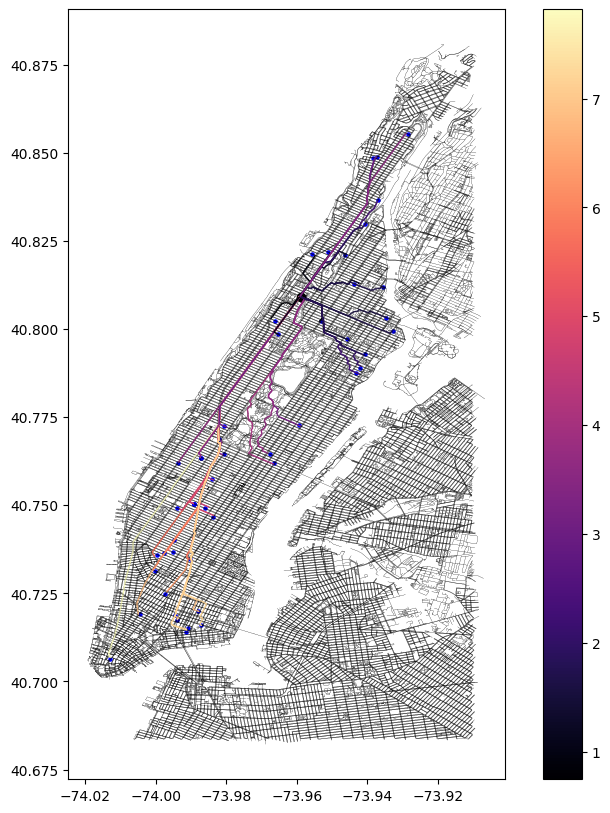

In [34]:
from shapely.geometry import box

# Define the bounding box for Manhattan
manhattan_bbox = box(-74.026675, 40.683935, -73.910408, 40.877483)

# Filter Manhattan network edges using the bounding box
mh_net_edges_manhattan = mh_net_edges[mh_net_edges.intersects(manhattan_bbox)]

# Filter burglary routes using the bounding box
mh_burglary_time_routes_manhattan = mh_burglary_time_routes[mh_burglary_time_routes.intersects(manhattan_bbox)]

# Filter burglary points using the bounding box
mh_burglary_time_manhattan = mh_burglary_time[mh_burglary_time.geometry.intersects(manhattan_bbox)]

# Create a plot with a specific size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot my apartment location
gpd.GeoSeries(my_apartment).plot(ax=ax, color="black", label="My Apartment")

# Plot filtered Manhattan network edges
mh_net_edges_manhattan.plot(ax=ax, color="black", linewidth=0.1)

# Plot filtered routes colored by distance using the 'magma' colormap
mh_burglary_time_routes_manhattan.plot(column="distance", cmap="magma", ax=ax, linewidth=1, legend=True)

# Plot burglary points
mh_burglary_time_manhattan.plot(ax=ax, color='blue', markersize=5, label='Burglary Points')

# Remove the axes for a cleaner look
# ax.set_axis_off()

# Add labels for each burglary point
for x, y, label in zip(mh_burglary_time_manhattan.geometry.x, mh_burglary_time_manhattan.geometry.y, mh_burglary_time_manhattan.dba):
    ax.text(x, y, label, fontsize=6)

# Add a label for the apartment
ax.text(my_apartment.x, my_apartment.y, "My Apartment", fontsize=8, color='red', ha='center')

# Set the title for the plot
plt.title("Distance from My Apartment to \n Burglary Crime from 10:00 PM to 11:00 AM in Manhattan", fontsize=12)

# Set the x and y limits to the bounding box coordinates
ax.set_xlim(manhattan_bbox.bounds[0], manhattan_bbox.bounds[2])
ax.set_ylim(manhattan_bbox.bounds[1], manhattan_bbox.bounds[3])

# Display the plot
plt.show()